In [50]:
### Import required libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from IPython.display import display # Allows the use of display() for DataFrames

import warnings
warnings.filterwarnings('ignore')
import datetime
import time

#Below Libraried for Plots
import matplotlib
#from mpl_toolkits.basemap import Basemap
from matplotlib import cm

sns.set(style="white", palette="muted", color_codes=True)
from haversine import haversine
from scipy.spatial.distance import euclidean , cityblock
from geopy.distance import great_circle
from math import *

from bokeh.io import output_notebook,show
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.palettes import Spectral4

import folium 
from folium import plugins
from folium.plugins import HeatMap

In [77]:
# Read train and test files
train_df = pd.read_csv(r'C:\Users\Anshul.Roy\Desktop\My Blog\Hands on SkLearn and Tensorflow\New York Taxi/train.csv')
test_df = pd.read_csv(r'C:\Users\Anshul.Roy\Desktop\My Blog\Hands on SkLearn and Tensorflow\New York Taxi/test.csv')

In [78]:
#Analyze Later . Test has no dropoff_datetime col
train_df["pickup_datetime"] = pd.to_datetime(train_df["pickup_datetime"])
train_df['day'] =  train_df['pickup_datetime'].dt.day
train_df['hour'] =  train_df['pickup_datetime'].dt.hour
train_df['weekday'] =  train_df['pickup_datetime'].dt.weekday
train_df["dropoff_datetime"] = pd.to_datetime(train_df["dropoff_datetime"])
#train_df["time_diff"] = pd.to_datetime(train_df["dropoff_datetime"]) - pd.to_datetime(train_df["pickup_datetime"])
test_df["pickup_datetime"] = pd.to_datetime(test_df["pickup_datetime"])
test_df['day'] =  test_df['pickup_datetime'].dt.day
test_df['hour'] =  test_df['pickup_datetime'].dt.hour
test_df['weekday'] =  test_df['pickup_datetime'].dt.weekday
train_df.head(1) #test_df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day,hour,weekday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,14,17,0


In [79]:
#Remove the key column (id)
train_df = train_df.drop("id", axis =1)
test_df = test_df.drop("id", axis =1)

In [54]:
test_df.head(1)

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,hour,weekday
0,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.75668,N,30,23,3


In [55]:
train_df.info() #Has one string field
#Two way to work on it. Convert N to 0 and Y to 1 or dummy encoding.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 13 columns):
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
day                   1458644 non-null int64
hour                  1458644 non-null int64
weekday               1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(6), object(1)
memory usage: 144.7+ MB


In [56]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 11 columns):
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
day                   625134 non-null int64
hour                  625134 non-null int64
weekday               625134 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 52.5+ MB


In [57]:
# One-hot encoding for categorical columns with get_dummies
#Ensure to execute after removing key columns or primary key columns
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [82]:
#train_df, train_cat_cols = one_hot_encoder(train_df, nan_as_category= True)
#test_df, test_cat_cols = one_hot_encoder(test_df, nan_as_category= True)
train_df['store_and_fwd_flag'][train_df.store_and_fwd_flag.values == 'Y'] = 1
test_df['store_and_fwd_flag'][test_df.store_and_fwd_flag.values == 'Y'] = 1
train_df['store_and_fwd_flag'][train_df.store_and_fwd_flag.values == 'N'] = 0
test_df['store_and_fwd_flag'][test_df.store_and_fwd_flag.values == 'N'] = 0

In [59]:
#### Check if there are any NULL values in Train Data
print("Total Train Features with NaN Values = " + str(train_df.columns[train_df.isnull().sum() != 0].size))
if (train_df.columns[train_df.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(train_df.columns[train_df.isnull().sum() != 0])))
    train_df[train_df.columns[train_df.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Train Features with NaN Values = 0


In [60]:
#### Check if there are any NULL values in Test Data
print("Total Test Features with NaN Values = " + str(test_df.columns[test_df.isnull().sum() != 0].size))
if (test_df.columns[test_df.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(test_df.columns[test_df.isnull().sum() != 0])))
    test_df[test_df.columns[test_df.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Test Features with NaN Values = 0


In [61]:
#Remove all the datetime cols
#train_df.drop(["pickup_datetime","dropoff_datetime"], axis = 1)
#test_df.drop(["pickup_datetime"], axis = 1)
#test_df.head(10)
#train_df.describe()

In [62]:
#Some EDA 
west, south, east, north = -74.03, 40.63, -73.77, 40.85

train_df = train_df[(train_df.pickup_latitude> south) & (train_df.pickup_latitude < north)]
train_df = train_df[(train_df.dropoff_latitude> south) & (train_df.dropoff_latitude < north)]
train_df = train_df[(train_df.pickup_longitude> west) & (train_df.pickup_longitude < east)]
train_df = train_df[(train_df.dropoff_longitude> west) & (train_df.dropoff_longitude < east)]

In [63]:
#Extract the month column from pickup datetime variable and take subset of data
train_df['dropoff_datetime'] = pd.to_datetime(train_df.dropoff_datetime)
train_df['dropoff_month'] = train_df['dropoff_datetime'].dt.month

heat_df =train_df.sample(n=2500)

#Extract required columns
heat_df = heat_df[['dropoff_latitude', 'dropoff_longitude','dropoff_month']]


# Ensure you're handing it floats
heat_df['dropoff_latitude'] = heat_df['dropoff_latitude'].astype(float)
heat_df['dropoff_longitude'] = heat_df['dropoff_longitude'].astype(float)


#remove NANs
heat_df = heat_df.dropna(axis=0)


# Create weight column, using date
heat_df['Weight'] = heat_df['dropoff_month']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['dropoff_latitude','dropoff_longitude', 'Weight'])

In [64]:
newyork_on_heatmap = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

# List comprehension to make out list of lists
heat_data = [[[row['dropoff_latitude'],row['dropoff_longitude']] 
                for index, row in heat_df[heat_df['Weight'] == i].iterrows()] 
                 for i in range(0,6)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap)

# Display the map
newyork_on_heatmap

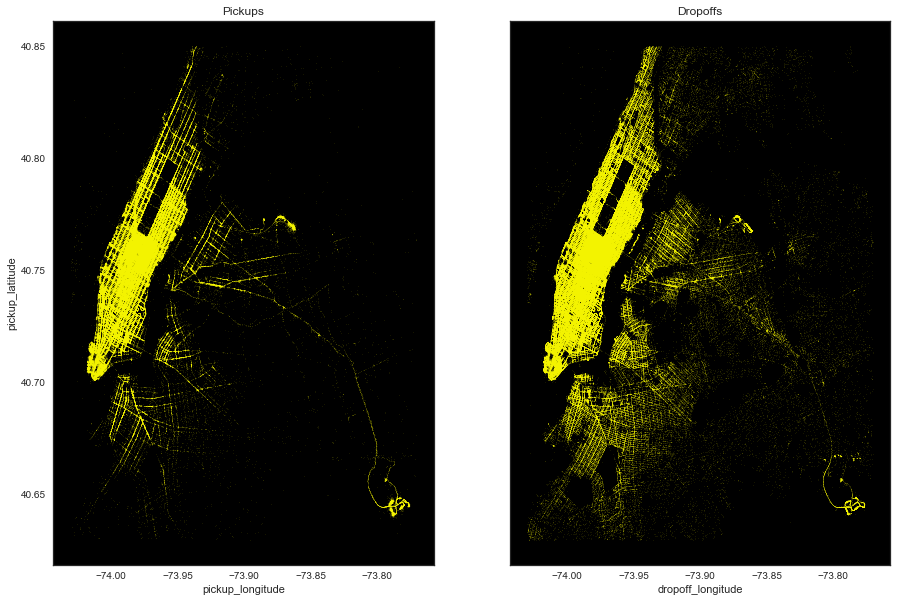

In [65]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

train_df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

train_df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 

In [66]:
#co-ordinates
LaGuardia = {
    "minLat": 40.76,
    "maxLat": 40.78,
    "minLong": -73.895,
    "maxLong": -73.855
}
train_df['pickup_datetime'] = pd.to_datetime(train_df.pickup_datetime)
train_df['dropoff_datetime'] = pd.to_datetime(train_df.dropoff_datetime)

LaGuardiaData = train_df[(train_df['pickup_longitude'].apply(lambda x: (x >=LaGuardia["minLong"]) & (x <= LaGuardia["maxLong"])))]
LaGuardiaData = train_df[(train_df['pickup_latitude'].apply(lambda x: (x >=LaGuardia["minLat"]) & (x <= LaGuardia["maxLat"])))]
LaGuardiaData = train_df[(train_df['dropoff_longitude'].apply(lambda x: (x >=LaGuardia["minLong"]) & (x <= LaGuardia["maxLong"])))]
LaGuardiaData = train_df[(train_df['dropoff_latitude'].apply(lambda x: (x >=LaGuardia["minLat"]) & (x <= LaGuardia["maxLat"])))]

m = folium.Map(
    location=[40.7769, -73.8740],
    zoom_start=12
)
folium.Marker(location=[40.7769, -73.8740],icon=folium.Icon(color='black') ,popup='LA Guardia International Airport').add_to(m)

shortTripsDF=LaGuardiaData[LaGuardiaData.trip_duration==900]

lines = [
    {
        'coordinates': [
            [shortTripsDF.pickup_longitude.iloc[index], shortTripsDF.pickup_latitude.iloc[index]],
            [shortTripsDF.dropoff_longitude.iloc[index], shortTripsDF.dropoff_latitude.iloc[index]],
        ],
        'dates': [
        str(shortTripsDF.pickup_datetime.iloc[index]),
        str(shortTripsDF.dropoff_datetime.iloc[index])
        ],
        'color': 'gold'
    }
    for index in range(100)
]
features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
        },
        'properties': {
            'times': line['dates'],
            'style': {
                'color': line['color'],
                'weight': line['weight'] if 'weight' in line else 10
            }
        }
    }
    for line in lines
]


plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT24H', add_last_point=True).add_to(m)
m

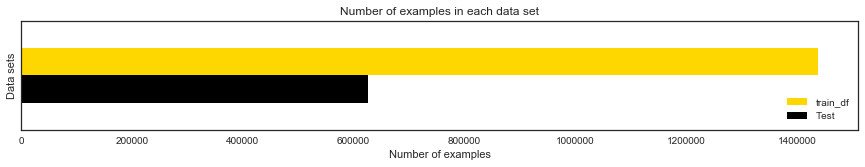

In [68]:
pd.DataFrame({'train_df': [train_df.shape[0]], 'Test': [test_df.shape[0]]}).plot.barh(
    figsize=(15, 2), legend='reverse',  color=["black","gold"])
plt.title("Number of examples in each data set")
plt.ylabel("Data sets")
plt.yticks([])
plt.xlabel("Number of examples");

In [69]:
print("Training headcount is %i." % train_df.shape[0])
print("Testing headcount is %i." % test_df.shape[0])

Training headcount is 1438626.
Testing headcount is 625134.


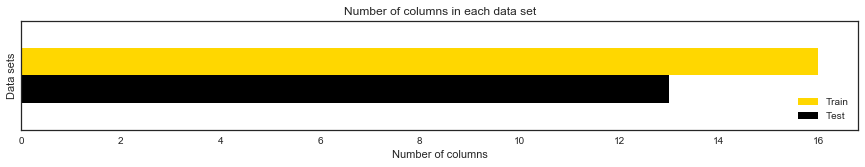

In [70]:
pd.DataFrame({'Train': [train_df.shape[1]], 'Test': [test_df.shape[1]]}).plot.barh(
    figsize=(15, 2), legend='reverse',  color=["black","gold"])
plt.title("Number of columns in each data set")
plt.ylabel("Data sets")
plt.yticks([])
plt.xlabel("Number of columns");

In [71]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,day,hour,weekday,store_and_fwd_flag_N,store_and_fwd_flag_Y,store_and_fwd_flag_nan,dropoff_month
count,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,945.99,15.50,13.62,3.05,0.99,0.01,0.00,3.52
std,0.50,1.31,0.04,0.03,0.03,0.03,5252.16,8.70,6.38,1.95,0.07,0.07,0.00,1.68
min,1.00,0.00,-74.03,40.63,-74.03,40.63,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,394.00,8.00,9.00,1.00,1.00,0.00,0.00,2.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,656.00,15.00,14.00,3.00,1.00,0.00,0.00,4.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1059.00,23.00,19.00,5.00,1.00,0.00,0.00,5.00
max,2.00,6.00,-73.77,40.85,-73.77,40.85,3526282.00,31.00,23.00,6.00,1.00,1.00,0.00,7.00


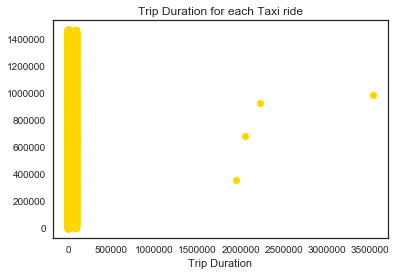

In [72]:
plt.scatter(train_df.trip_duration,train_df.index,color="gold")
plt.xlabel("Trip Duration")
plt.title("Trip Duration for each Taxi ride");

In [73]:
train_df['log_trip_duration'] = np.log1p(train_df['trip_duration'].values)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


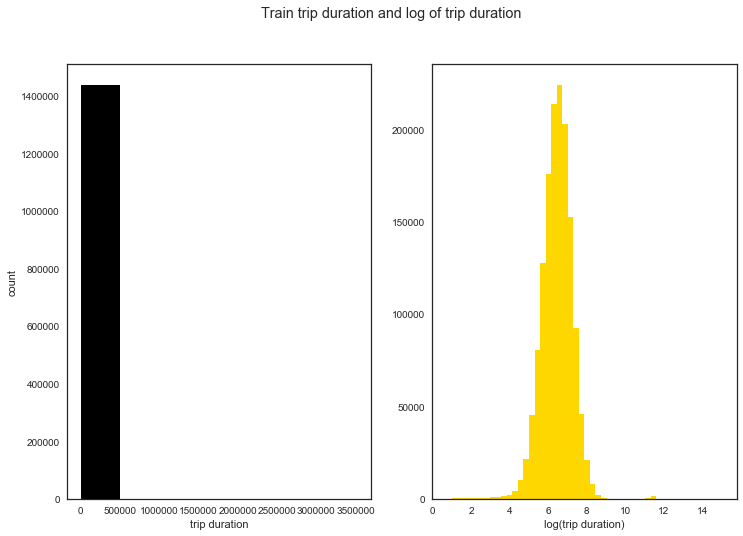

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,8))
fig.suptitle('Train trip duration and log of trip duration')
ax1.legend(loc=0)
ax1.set_ylabel('count')
ax1.set_xlabel('trip duration')
ax2.set_xlabel('log(trip duration)')
ax2.legend(loc=0)
ax1.hist(train_df.trip_duration,color='black',bins=7)
ax2.hist(train_df.log_trip_duration,bins=50,color='gold');

In [75]:
print("Skewness: %f" % train_df['log_trip_duration'].skew())
print("Kurtosis: %f" % train_df['log_trip_duration'].kurt())

Skewness: -0.265401
Kurtosis: 3.881358


In [81]:
train_df['pickup_datetime'] = pd.to_datetime(train_df.pickup_datetime)
test_df['pickup_datetime'] = pd.to_datetime(test_df.pickup_datetime)
train_df['dropoff_datetime'] = pd.to_datetime(train_df.dropoff_datetime)


for df in (train_df,test_df):
    # Dates
    df['pickup_date'] = df['pickup_datetime'].dt.date

    # day of month 1 to 30/31
    df['pickup_day'] = df['pickup_datetime'].dt.day

    #month of year 1 to 12
    df['pickup_month'] = df['pickup_datetime'].dt.month

    #weekday 0 to 6
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday


    #week of year
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear

    #hour of day 0 to 23
    df['pickup_hour'] = df['pickup_datetime'].dt.hour

    #minute of hour
    df['pickup_minute'] = df['pickup_datetime'].dt.minute

    # day of year
    df['pickup_dayofyear'] = df['pickup_datetime'].dt.dayofyear

train_df['pickup_dt'] = (train_df['pickup_datetime'] - train_df['pickup_datetime'].min()).dt.total_seconds()
train_df['pickup_week_hour'] = train_df['pickup_weekday'] * 24 + train_df['pickup_hour']


test_df['pickup_dt'] = (test_df['pickup_datetime'] - train_df['pickup_datetime'].min()).dt.total_seconds()
test_df['pickup_week_hour'] = test_df['pickup_weekday'] * 24 + test_df['pickup_hour']

In [87]:
X_train = train_df.drop(["trip_duration","pickup_datetime","dropoff_datetime","store_and_fwd_flag","pickup_date","pickup_dt"], axis=1)
y_train = np.log1p(train_df["trip_duration"].values)

X_test = test_df.drop(["pickup_datetime","store_and_fwd_flag","pickup_date","pickup_dt"], axis=1)

In [88]:
dev_X, val_X, dev_y, val_y = sklearn.model_selection.train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
X_train.head(10)


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,day,hour,weekday,pickup_day,pickup_month,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_dayofyear,pickup_week_hour
0,2,1,-73.98,40.77,-73.96,40.77,14,17,0,14,3,0,11,17,24,74,17
1,1,1,-73.98,40.74,-74.00,40.73,12,0,6,12,6,6,23,0,43,164,144
2,2,1,-73.98,40.76,-74.01,40.71,19,11,1,19,1,1,3,11,35,19,35
3,2,1,-74.01,40.72,-74.01,40.71,6,19,2,6,4,2,14,19,32,97,67
4,2,1,-73.97,40.79,-73.97,40.78,26,13,5,26,3,5,12,13,30,86,133
5,2,6,-73.98,40.74,-73.99,40.75,30,22,5,30,1,5,4,22,1,30,142
6,1,4,-73.97,40.76,-73.96,40.77,17,22,4,17,6,4,24,22,34,169,118
7,2,1,-73.97,40.80,-73.92,40.76,21,7,5,21,5,5,20,7,54,142,127
8,1,1,-74.00,40.74,-73.99,40.73,27,23,4,27,5,4,21,23,12,148,119
9,2,1,-73.98,40.74,-73.97,40.79,10,21,3,10,3,3,10,21,45,70,93


In [104]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42,
  
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=50, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

# Training LGB
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 0.757037
[100]	valid_0's rmse: 0.723451
[150]	valid_0's rmse: 0.694698
[200]	valid_0's rmse: 0.673175
[250]	valid_0's rmse: 0.65485
[300]	valid_0's rmse: 0.639771
[350]	valid_0's rmse: 0.627451
[400]	valid_0's rmse: 0.616074
[450]	valid_0's rmse: 0.605478
[500]	valid_0's rmse: 0.598014
[550]	valid_0's rmse: 0.592
[600]	valid_0's rmse: 0.584255
[650]	valid_0's rmse: 0.57901
[700]	valid_0's rmse: 0.573664
[750]	valid_0's rmse: 0.568996
[800]	valid_0's rmse: 0.564476
[850]	valid_0's rmse: 0.560778
[900]	valid_0's rmse: 0.556745
[950]	valid_0's rmse: 0.552628
[1000]	valid_0's rmse: 0.549248
[1050]	valid_0's rmse: 0.545999
[1100]	valid_0's rmse: 0.543294
[1150]	valid_0's rmse: 0.540403
[1200]	valid_0's rmse: 0.537795
[1250]	valid_0's rmse: 0.534048
[1300]	valid_0's rmse: 0.531147
[1350]	valid_0's rmse: 0.529107
[1400]	valid_0's rmse: 0.527327
[1450]	valid_0's rmse: 0.525333
[1500]	valid_0's rmse: 0.523495
[1

In [111]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:10])

Features Importance...
             feature       gain  split
3    pickup_latitude  25.503347  35678
2   pickup_longitude  23.668370  32953
4  dropoff_longitude  22.579911  33295
5   dropoff_latitude  21.193053  36290
8               hour   4.471326  21522
7            weekday   1.878934  13386
6                day   0.314335  14730
1    passenger_count   0.200392   4163
0          vendor_id   0.190332   2983


In [100]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'reg:linear', 
                    #reg:linear” –linear regression
                    #reg:logistic” –logistic regression
                    #binary:logistic” –logistic regression for binary classification, output probability
                    #“multi:softmax” –set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
          'eval_metric': 'rmse',
                          #“rmse”: root mean square error
                          #“mae”: mean absolute error
                          #“logloss”: negative log-likelihood
                          #“error”: Binary classification error rate. It is calculated as #(wrong cases)/#(all cases). For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.
                          #“merror”: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).
                          #“mlogloss”: Multiclass logloss
                          #“auc”: Area under the curve for ranking evaluation.
          'eta': 0.005,
          'max_depth': 10, 
          'subsample': 0.7, 
          'colsample_bytree': 0.5,
          'alpha':0,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 30, verbose_eval=50)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return xgb_pred_y, model_xgb
# Training XGB
pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y, X_test)
print("XGB Training Completed...")

[0]	train-rmse:5.98989	valid-rmse:5.99137
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:4.68241	valid-rmse:4.68405
[100]	train-rmse:3.66755	valid-rmse:3.6694
[150]	train-rmse:2.88406	valid-rmse:2.88617
[200]	train-rmse:2.27864	valid-rmse:2.28104
[250]	train-rmse:1.81491	valid-rmse:1.81768
[300]	train-rmse:1.46332	valid-rmse:1.46656
[350]	train-rmse:1.19792	valid-rmse:1.20175
[400]	train-rmse:1.00052	valid-rmse:1.00501
[450]	train-rmse:0.858448	valid-rmse:0.863676
[500]	train-rmse:0.755722	valid-rmse:0.761658
[550]	train-rmse:0.685874	valid-rmse:0.692525
[600]	train-rmse:0.637199	valid-rmse:0.644492
[650]	train-rmse:0.604156	valid-rmse:0.611998
[700]	train-rmse:0.580126	valid-rmse:0.588508
[750]	train-rmse:0.56526	valid-rmse:0.574135
[800]	train-rmse:0.554284	valid-rmse:0.563628
[850]	train-rmse:0.545113	valid-rmse:0.554905
[900]	train-rmse:0.538098	valid-rmse:0.548317
[950

In [101]:
cb_model = CatBoostRegressor(iterations=750,
                             learning_rate=0.1,
                             depth=7,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 20,
                             od_wait=20)
cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=True)

0:	learn: 5.8710276	test: 5.8724785	best: 5.8724785 (0)	total: 607ms	remaining: 7m 34s
20:	learn: 0.9377331	test: 0.9398593	best: 0.9398593 (20)	total: 11.1s	remaining: 6m 25s
40:	learn: 0.5708117	test: 0.5730493	best: 0.5730493 (40)	total: 21.6s	remaining: 6m 14s
60:	learn: 0.5331495	test: 0.5355487	best: 0.5355487 (60)	total: 32.1s	remaining: 6m 2s
80:	learn: 0.5160663	test: 0.5184882	best: 0.5184882 (80)	total: 42.8s	remaining: 5m 53s
100:	learn: 0.4994849	test: 0.5019911	best: 0.5019911 (100)	total: 53.5s	remaining: 5m 43s
120:	learn: 0.4888639	test: 0.4914214	best: 0.4914214 (120)	total: 1m 4s	remaining: 5m 33s
140:	learn: 0.4799693	test: 0.4825654	best: 0.4825654 (140)	total: 1m 14s	remaining: 5m 22s
160:	learn: 0.4729205	test: 0.4755852	best: 0.4755852 (160)	total: 1m 25s	remaining: 5m 11s
180:	learn: 0.4676442	test: 0.4703639	best: 0.4703639 (180)	total: 1m 35s	remaining: 5m 1s
200:	learn: 0.4634217	test: 0.4661497	best: 0.4661497 (200)	total: 1m 46s	remaining: 4m 50s
220:	lear

In [102]:
pred_test_cat = np.expm1(cb_model.predict(X_test))

In [105]:
sub = pd.read_csv(r'C:\Users\Anshul.Roy\Desktop\My Blog\Hands on SkLearn and Tensorflow\New York Taxi\sample_submission.csv')
sub = sub.drop("trip_duration",axis=1)
sub_lgb = pd.DataFrame()
sub_lgb["target"] = pred_test

sub_xgb = pd.DataFrame()
sub_xgb["target"] = pred_test_xgb

sub_cat = pd.DataFrame()
sub_cat["target"] = pred_test_cat

sub["trip_duration"] = (sub_lgb["target"] + sub_xgb["target"] + sub_cat["target"])/3
print(sub.head(5))
sub.to_csv('sample_submission.csv', index=False)

          id  trip_duration
0  id3004672         713.83
1  id3505355         451.01
2  id1217141         430.27
3  id2150126        1029.20
4  id1598245         321.57
